## Clustering the discrete embeddings


In [1]:
import os
import numpy as np
import pandas as pd
import json
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import random
import copy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.sparse import lil_matrix
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
graphname = 'Pubmed'
emb_size = 10
data_dir = os.path.expanduser("../Graphs/"+graphname)

In [3]:
k = 4 # number of clusters

In [4]:
jsonpath = data_dir + "/vectors/vectors_l1_all_" + str(emb_size) + ".json"
# os.path.join(data_dir, "vectors_l1_all_" + str(emb_size) + ".json")
with open(jsonpath, 'r') as infile:
    embeddings_l1 = json.load(infile)

In [5]:
def get_dict(embeddings_l1, idx):
    all_words = {}
    for node, features in embeddings_l1.items():
        for f in features:
            word = f[idx]
            if word not in all_words:
                all_words[word] = len(all_words)
    return all_words

In [6]:
all_words = get_dict(embeddings_l1, 2)

In [7]:
len(embeddings_l1), len(all_words)

(19717, 500)

In [8]:
def get_sparse_matrix(embeddings, all_words, idx):
    S = lil_matrix((len(embeddings), emb_size*len(all_words)))
    print(S.count_nonzero())
    row = 0
    cnt = 0
    nodelist = []
    for node, emb in embeddings.items():
        col = 0
        for feats in emb:
            word=feats[idx]
            S[row, col*len(all_words) + all_words[word]] = 1 
            cnt += 1
            col += 1
        row += 1
        nodelist.append(node)
    print(S.count_nonzero())
    print('cnt', cnt)
    return S, nodelist

In [9]:
S_l1, nodes_l1 = get_sparse_matrix(embeddings_l1, all_words, 2)

0
197170
cnt 197170


In [10]:
S_l1.shape

(19717, 5000)

In [11]:
def clustering(S, k, random_state):
    Spca = copy.deepcopy(S) 
    labeler = KMeans(n_clusters=k, init='k-means++', random_state=random_state)
    labels = labeler.fit_predict(Spca)
    nr_labels = [0 for _ in range(k)]
    for label in labels:
        nr_labels[label] += 1
    print('Label distribution', nr_labels)
    return labels

In [12]:
labels_l1 = clustering(S_l1, k=4, random_state=73)

Label distribution [17364, 941, 608, 804]


In [13]:
def get_top(d, top):
    s = sum([cnt for _, cnt in d.items()])
    return sorted([(np.round(cnt/s, 3), w) for w, cnt in d.items()], reverse=True)[:top]

In [14]:
def top_words_per_cluster(S, k, labels, all_words, nr_top_words):
    all_words_rev = {i:w for w, i in all_words.items()}
    words_per_cluster = [{} for _ in range(k)]
    for i, label in enumerate(labels):
        if i % 1000 == 0:
            print('example with label', i, label)
        words_label = words_per_cluster[label]
        for j in range(len(all_words)):
            if S[i, j] != 0:
                words_label.setdefault(all_words_rev[j], 0)
                words_label[all_words_rev[j]] += 1
                
    top_words = set()
    for label in range(k):
        print(get_top(words_per_cluster[label], nr_top_words))
        for weight, word in get_top(words_per_cluster[label], nr_top_words):
            top_words.add(word)
    print(top_words)    
    word_distr = [[] for _ in range(k)]
    for label in range(k):
        sum_label = sum([cnt for _, cnt in words_per_cluster[label].items()])
        for tw in top_words:
            if tw in words_per_cluster[label]:
                #print(tw, np.round(words_per_cluster[label][tw]/sum_label, 3))
                word_distr[label].append((tw, np.round(words_per_cluster[label][tw]/sum_label, 4)))
            else:
                word_distr[label].append((tw, 0))
    return word_distr, top_words
    

In [15]:
word_distr, top_words = top_words_per_cluster(S_l1, k=k, labels=labels_l1, all_words=all_words, nr_top_words=8)

example with label 0 0
example with label 1000 0
example with label 2000 0
example with label 3000 3
example with label 4000 0
example with label 5000 0
example with label 6000 0
example with label 7000 0
example with label 8000 0
example with label 9000 0
example with label 10000 0
example with label 11000 0
example with label 12000 0
example with label 13000 0
example with label 14000 0
example with label 15000 0
example with label 16000 0
example with label 17000 0
example with label 18000 0
example with label 19000 0
[(0.022, 'w-0'), (0.012, 'w-onset'), (0.012, 'w-mg'), (0.011, 'w-cell'), (0.01, 'w-level'), (0.01, 'w-associ'), (0.009, 'w-signific'), (0.009, 'w-insulin')]
[(0.108, 'w-chang'), (0.073, 'w-achiev'), (0.063, 'w-men'), (0.045, 'w-particip'), (0.037, 'w-onset'), (0.032, 'w-locus'), (0.024, 'w-conclus'), (0.023, 'w-metformin')]
[(0.15, 'w-correl'), (0.048, 'w-drug'), (0.044, 'w-manag'), (0.041, 'w-failur'), (0.039, 'w-cohort'), (0.035, 'w-postprandi'), (0.033, 'w-increas')

In [16]:
def plot_words_distr(word_distr, k, top_words, xlimit):
    plt.figure(figsize=(10,6), dpi=80)
    linewidth=7
    alpha=0.6
    words = []
    plot_nr = 100 + 10*k
    for cluster_nr in range(1, k+1):
        plt.subplot(plot_nr+cluster_nr)
        plt.hlines(y=0, xmin = 0, xmax = xlimit, color='red', alpha=0, linewidth=linewidth)
        plt.hlines(y=1, xmin = 0, xmax = 1/2**4, color='red', alpha=0, linewidth=linewidth)
        words = []
        for i, word_val in enumerate(word_distr[cluster_nr-1]):
            plt.hlines(y = i+1, xmin = 0, xmax = word_val[1], color='blue', alpha=alpha, linewidth=linewidth)
            word = word_val[0].split('-')[1]
            l = max(0, 9 - len(word))
            complete = l*'  ' + word
            words.append(complete)
        plt.xscale('log', basex=2)
        plt.xticks([1/2**5, 0.5])
        plt.xlim(0, xlimit)
        plt.yticks(ticks=[i + 1 for i in range(len(top_words))], labels=words, size=12)
        plt.title('Cluster '+str(cluster_nr))
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


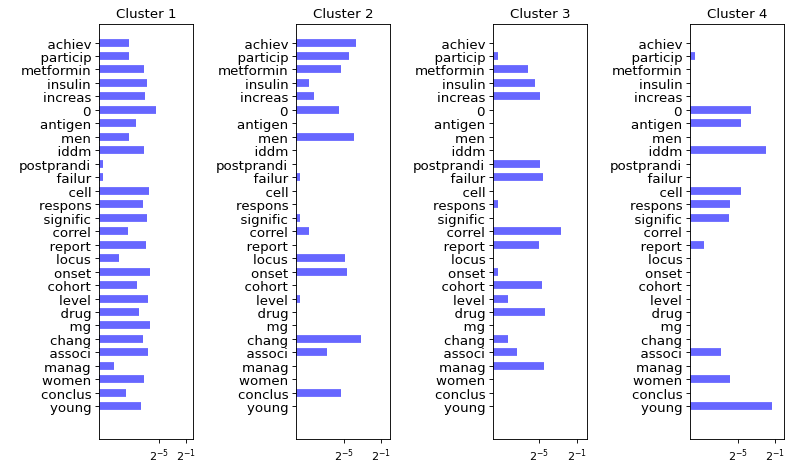

In [17]:
plot_words_distr(word_distr, k=k, top_words=top_words, xlimit=1)

In [18]:
def get_dominating_words(nodes, labels, embeddings, coordinate, threshold=0.025):

    clusters = [{} for _ in range(k)]
    for n, l in zip(nodes, labels):
        
        c = coordinate
        word = embeddings[n][c][2]
        clusters[l].setdefault(word, 0)
        clusters[l][word] += 1
    
    res = {}
    for cl in range(k):
        s = sum([weight for word, weight in clusters[cl].items()])
        top_words = []
        for word, weight in clusters[cl].items():
            if weight > s*threshold:
                top_words.append(word.split('-')[1])
        res[cl] = top_words 
    print(res)

In [34]:
get_dominating_words(nodes_l1, labels_l1, embeddings_l1, coordinate=1, threshold=0.05)

{0: [], 1: ['increas', '7', 'glycem', 'x'], 2: ['incid', 'type', '95', '6', 'progress', 'vascular'], 3: ['receptor', 'shown']}


In [20]:
jsonpath = data_dir + "/vectors/vectors_rwalk_all_" + str(emb_size) + ".json"
#os.path.join(data_dir, "vectors_rwalk_all_" + str(emb_size) + ".json")
with open(jsonpath, 'r') as infile:
    embeddings_rw = json.load(infile)

In [21]:
all_words_rw = get_dict(embeddings_rw, 2)

In [22]:
S_rw, nodes_rw = get_sparse_matrix(embeddings_rw, all_words_rw, 2)

0
197170
cnt 197170


In [23]:
labels_rw = clustering(S_rw, k=k, random_state=73)

Label distribution [18787, 315, 444, 171]


In [24]:
word_distr_rw, top_words_rw = \
top_words_per_cluster(S_rw, k=k, labels=labels_rw, all_words=all_words_rw, nr_top_words=8)

example with label 0 0
example with label 1000 0
example with label 2000 0
example with label 3000 0
example with label 4000 0
example with label 5000 0
example with label 6000 0
example with label 7000 0
example with label 8000 0
example with label 9000 0
example with label 10000 0
example with label 11000 0
example with label 12000 3
example with label 13000 0
example with label 14000 0
example with label 15000 0
example with label 16000 0
example with label 17000 0
example with label 18000 0
example with label 19000 0
[(0.01, 'w-rat'), (0.009, 'w-patient'), (0.008, 'w-cell'), (0.008, 'w-0'), (0.007, 'w-mice'), (0.007, 'w-insulin'), (0.006, 'w-p'), (0.006, 'w-glucos')]
[(0.019, 'w-0'), (0.013, 'w-week'), (0.013, 'w-treatment'), (0.013, 'w-risk'), (0.013, 'w-95'), (0.013, 'w-8'), (0.01, 'w-year'), (0.01, 'w-women')]
[(0.191, 'w-gene'), (0.016, 'w-0'), (0.014, 'w-age'), (0.009, 'w-week'), (0.009, 'w-risk'), (0.009, 'w-rang'), (0.009, 'w-patient'), (0.007, 'w-type')]
[(0.029, 'w-nerv'),

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


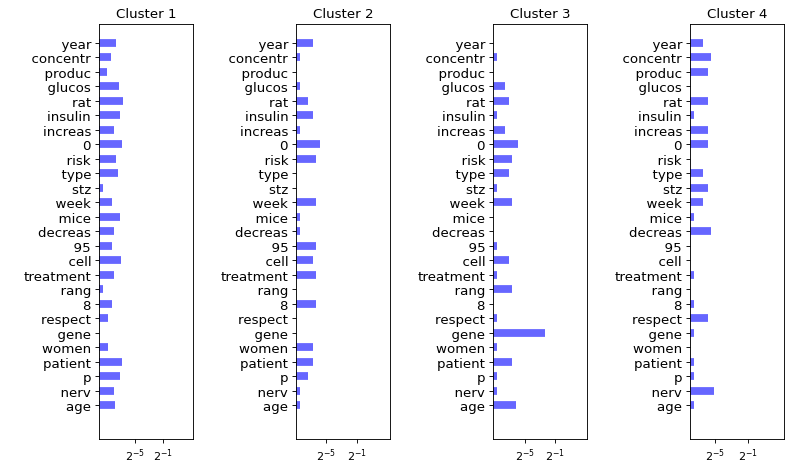

In [25]:
plot_words_distr(word_distr_rw, k=k, top_words=top_words_rw, xlimit=10)

In [32]:
get_dominating_words(nodes_rw, labels_rw, embeddings_rw, coordinate=0, threshold=0.05)

{0: [], 1: [], 2: ['gene'], 3: []}
